# Comparing execution times: `SurrealML` vs `ONNX` vs `PyTorch` 

## Table of contents

1.  <a href="#1">General dependencies and helpers</a>
2.  <a href="#2">Some words about SurrealML</a>
3.  <a href="#3">Problem refinement</a>
4.  <a href="#4">A typical neural network</a>
5.  <a href="#5">Loading the model to SurrealDB</a>
6.  <a href="#6">Generating and inserting fake data to SurrealDB</a>

<h2 id="1"></h2>

## General dependencies and helpers

We will start by exporting some tools we will use for timing, and operating with SurrealDB/SurrrealML...

In [9]:
import os
import subprocess
import time
from functools import wraps

import torch
import torch.nn as nn

from surrealml import SurMlFile, Engine
from surrealist import Surreal
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.magic import register_cell_magic


def chronometer(foo):
    @wraps(foo)
    def wrapper(*args, **kwargs):
        start = time.time()
        _ = foo(*args, **kwargs)
        end = time.time()
        return end - start

    return wrapper


@register_cell_magic
def skip(line, cell):
    return

<h2 id="2"></h2>

## Some words about SurrealML

According to the [official docs](https://surrealdb.com/docs/surrealml):
    
```text
SurrealML is an engine that seeks to do one thing, and one thing well: store and execute trained ML models. SurrealML does not intrude on the training frameworks that are already out there, instead works with them to ease the storage, loading, and execution of models. Someone using SurrealML will be able to train their model in a chosen framework in Python, save their model, and load and execute the model in either Python or Rust.
```

Basically, we aim to develop and train models using `PyTorch/scikit-learn/Tensorflow/linfa`, and then load them to SurrealDB.

Inside SurrealDB, a model is represented in the [.surml format](https://surrealdb.com/docs/surrealml/storage#the-anatomy-of-a-surml-file). Schematically, from top to bottom of a .surml file, we roughly have that:

`.surml file` =  `4 byte integer` + `variable metadata [size specified by 4 bytes integer]` + `model parameters [ONNX format]`

A .surml file is loaded by starting with the 4 bytes integer, and then using it to determine the length of the model metadata. Once the model metadata has been loaded, the loader assumes that the rest is ONNX protobuf, and parses it accordingly.

At the time of writing, in the [source code](https://github.com/surrealdb/surrealml/blob/main/surrealml/engine/__init__.py) of the `Engine` enum, we have the following docstring:

_Attributes_:
- **PYTORCH**: The PyTorch engine which will be PyTorch and ONNX.
- **NATIVE**: The native engine which will be native Rust and Linfa.
- **SKLEARN**: The scikit-learn engine which will be scikit-learn and ONNX.
- **TENSORFLOW**: The TensorFlow engine which will be TensorFlow and ONNX.
- **ONNX**: The ONNX engine which bypasses the conversion to ONNX.

Thus, we may infer that, for the sake of comparing `SurrealML` vs `ONNX` vs `PyTorch`, for the same model, it should be equivalent using `Engine.PYTORCH`/`Engine.SKLEARN`/`Engine.TENSORFLOW`, as irrespective of the framework used, the model will be exported to the ONNX first.

<a id="3"></a>

## Problem refinement

We single out three cases that may be encountered in practice, namely:

1. **Execute with SurrealML[inside SurrealDB] && fetch data from SurrealDB [optional]**: predicting with the model in .surml format _inside_ the SurrealDB, and then _optionally_ fetching the prediction from SurrealDB.
2. **Fetch data from SurrealDB && execute with PyTorch**: fetching the data from SurrealDB and _externally_ predicting with the PyTorch model.
3. **Fetch data from SurrealDB && execute with ONNX runtime**: fetching the data from SurrealDB and _externally_ predicting with the ONNX model.

Given the 3 scenarios above, one may deduct the following benefits of using SurrealML:

- **Reduced Database Transactions**
  - No need to fetch data from SurrealDB if predictions are not consumed immediately.
  - Eliminates at least **2 database transactions**, if fetching the input data and inserting the computed predictions is not needed anymore.

- **Improved Security**
  - Operates on the input used for predictions, as well as on the calculated predictions, without needing to retrieve it from the database, enhancing security.


However, one may be curious about the `performance` of SurrealML, so we will provide an implementation of an experiment to measure just this.

<h2 id="4"></h2>

## A toy neural network

In the following, we define `ToyNet`, which is a two-layer feedforward neural network with ReLU activation. It consists of an input layer with 10 features, a hidden layer of 5 neurons (`fc1`), and an output layer of 1 neuron (`fc2`).

In [10]:
class ToyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def __str__(self) -> str:
        return self.__class__.__name__

... and then we instantiate the model, and load a persistent version of the randomly intialized parameters of the model, from a previous run: 

In [11]:
model = ToyNet()
# torch.save(model.state_dict(), "./params.pth")
model.load_state_dict(torch.load("params.pth"))

<All keys matched successfully>

<h2 id="5"></h2>

## Starting a SurrealDB instance

It is high time to start a SurrealDB instance, ready to be accessed at the port `53333` of `localhost`. In the same directory as this notebook, there is the script `download_surreal_db_v1.5.5.sh`. We make it executable first, and then run it, noting that we have to echo the pasword of the current user...

In [12]:
! chmod +x ./download_surreal_db_v1.5.5.sh && echo "vld28" | sudo -S echo "Caching password..." && ./download_surreal_db_v1.5.5.sh

[sudo] password for vld28: Caching password...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 16.1M  100 16.1M    0     0  11.5M      0  0:00:01  0:00:01 --:--:-- 26.0M
Please enter your password to move the SurrealDB binary to /usr/local/bin...
SurrealDB v1.5.5 installed successfully.


In [4]:
URL = "http://0.0.0.0:53333"
NS = "comparison_test"
DB = "surrealml_vs_onnx_vs_pytorch"

__NOTE__: From here on, we mention that this notebook has been tested explicitly and found compatible with __v.1.5.4-1.5.5__ of SurrealDB. 

 For convenience, we may start the database in memory, however please mind that you will need to have at least of 2.7 GB of extra memory to perform the performance test below...

In [5]:
"""

current_directory = os.getcwd()
mount_directory = os.path.join(current_directory, "mnt")

docker_run_command = [
    "docker",
    "run",
    "-e",
    "RUST_BACKTRACE=full",
    "--name",
    "surrealdb",
    "--rm",
    "--pull",
    "always",
    "-p",
    "8000:8000",
    "--user",
    "root",
    "-v",
    f"{mount_directory}:/data_app",
    "-v",
    "/usr/local/lib:/onnxruntime/lib",
    "surrealdb/surrealdb:v1.5.5",
    "start",
    "file:/data_app/mydatabase.db",
]

container_process = subprocess.Popen(docker_run_command)
time.sleep(4)
"""

'\n\ncurrent_directory = os.getcwd()\nmount_directory = os.path.join(current_directory, "mnt")\n\ndocker_run_command = [\n    "docker",\n    "run",\n    "-e",\n    "RUST_BACKTRACE=full",\n    "--name",\n    "surrealdb",\n    "--rm",\n    "--pull",\n    "always",\n    "-p",\n    "8000:8000",\n    "--user",\n    "root",\n    "-v",\n    f"{mount_directory}:/data_app",\n    "-v",\n    "/usr/local/lib:/onnxruntime/lib",\n    "surrealdb/surrealdb:v1.5.5",\n    "start",\n    "file:/data_app/mydatabase.db",\n]\n\ncontainer_process = subprocess.Popen(docker_run_command)\ntime.sleep(4)\n'

<h2 id="6"></h2>

## Loading the model to SurrealDB

As we know from the Engine docstring, under the hood SurrealML converts any PyTorch/scikit-learn/Tensorflow model to the ONNX format, hence we switch the model to inference mode:

In [6]:
model.eval()

ToyNet(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

The `SurMlFile` object comes in handy to save our model in the `.surml` format. As our model was developed using PyTorch, we select the `Engine.PYTORCH` option:

In [7]:
# Owing to the fact that the SURML format builds on the ONNX format, we have to specify an example input
example_input = torch.rand(1, 10)
surml_file = SurMlFile(
    model=model, name=str(model), inputs=example_input, engine=Engine.PYTORCH
)

# we also choose a local path where to save the model, as well as a version of the model
path_surml = "./model.surml"
surml_file.add_version("0.0.1")
surml_file.save(path_surml)

/home/vld28/Desktop/dev/article/surrealml-vs-onnx-vs-pytorch/surrealml-vs-onnx-vs-pytorch/.venv/lib/python3.11/site-packages/torch/onnx/utils.py:847: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x7fd4c45f5f50>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")


Subsequently, we will use the SurrealDB CLI programatically to upload the model to SurrealDB:

In [13]:
try:
    command_import_model = [
        "surreal",
        "ml",
        "import",
        "--endpoint",
        "http://0.0.0.0:8000",
        "--ns",
        "comparison_test",
        "--db",
        "surrealml_vs_onnx_vs_pytorch",
        "model.surml",
    ]
    output = subprocess.check_output(command_import_model, stderr=subprocess.STDOUT)
    print(output.decode("utf-8"))
except subprocess.CalledProcessError as e:
    print(f"Command '{e.cmd}' failed with return code {e.returncode}.")
    print("Output:\n", e.output.decode("utf-8"))

Command '['surreal', 'ml', 'import', '--endpoint', 'http://0.0.0.0:8000', '--ns', 'comparison_test', '--db', 'surrealml_vs_onnx_vs_pytorch', 'model.surml']' failed with return code 1.
Output:
 2024-10-18T08:06:58.729608Z ERROR surreal::cli: There was a problem with the database: There was an error processing a remote HTTP request: error sending request for url (http://0.0.0.0:8000/health): error trying to connect: tcp connect error: Connection refused (os error 111)



According to the last logs, that resulted from executing the `surreal ml` command inside the `surrealdb` Docker container, the .surml file should be in SurrealDB. By using the [surreal sql](https://surrealdb.com/docs/surrealdb/cli/sql#sql-command) command inside the `surrealdb` container as well, I can see that the model was correctly uploaded to SurrealDB:

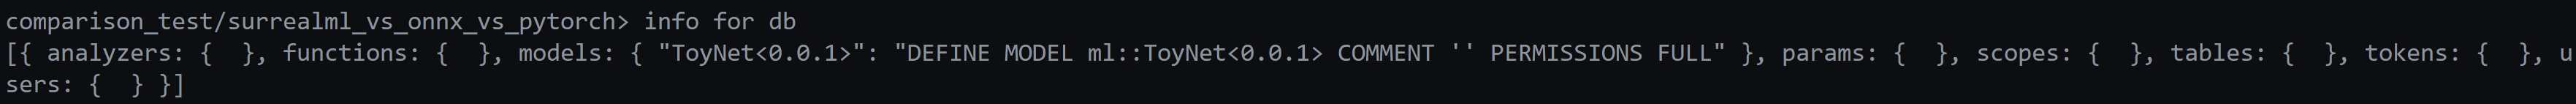

According to the documentation, the instance of the SurMlFile has an equivalent `.upload()` method, however I could not figure out what I did wrongly...

In [9]:
%%skip
"""
###################################################################################################
--> The other way to upload a model to SurrealDB. Could not make it work by the time of writing :( 
###################################################################################################
"""
surml_file.upload(
    path="./model.surml",
    url=URL,
    chunk_size=36864,
    namespace=NS,
    database=DB,
    username=USR,
    password=PASS)


<h2 id="6"></h2>

## Generating and inserting fake data to SurrealDB

We connect to SurrealDB and insert randomly generated test data in batches defined by max_test_size = $2^{26}$ datapoints, split into chunks of chunk_size = $2^{16}$.

 Knowing that a datapoint is effectively a random float value, some back-of-the-envelope calculations (assuming that we operate on single precision) lead us to 4 bytes per float * 10 floats (the size of the input of our model) * $2^{24}$ ≈ `1.25 GB`. In case your machine supports less than this, or, on the contrary, you want to do more extensive benchmarking, adjust the values below accordingly.

In [10]:
max_test_size = 2**20  # adjust based on disk size
chunk_size = 2**14  # adjust this according to RAM size
number_chunks = max_test_size // chunk_size

URL = "http://localhost:8000"
NS = "comparison_test"
DB = "surrealml_vs_onnx_vs_pytorch"

surreal = Surreal(
    url=URL,
    namespace=NS,
    database=DB,
    timeout=10**8,
)

Let us create the fake inputs of size 10 datapoints, coming in batches of $2^{16}$ inputs...

In [11]:
with surreal.connect() as connect:
    print("a")
    for _ in range(number_chunks):
        test_inputs = torch.rand(chunk_size, 10).tolist()
        for test_input in test_inputs:
            query = f"CREATE inputs:ulid() SET input = {test_input};"
            result = connect.query(query)

            if result.status == "OK":
                continue
            else:
                print(f"Failed to insert: {test_input}, Result: {result.result}")

a


KeyboardInterrupt: 

In [33]:
@chronometer
def evaluate_with_surrealdb(test_size, connect):
    query = f"""
    SELECT VALUE ml::ToyNet<0.0.1>(input)
    FROM inputs
    LIMIT {test_size}
    """
    a = connect.query(query)
    print(a.result)

In [34]:
#os.environ["ONNXRUNTIME_LIB_PATH"] = "/usr/local/lib"

surreal_times = {}
test_step = 2**3
number_steps = number_chunks // test_step

try:
    with surreal.connect() as connect:
        for increment in range(number_steps):
            test_size = (increment + 1) * test_step
            elapsed_time = evaluate_with_surrealdb(test_size, connect)
            print(
                f"For {test_size} collections of 10 by {chunk_size} datapoints, it took {elapsed_time} seconds"
            )
            surreal_times[test_size] = elapsed_time
except Exception as e:
    print(e)

[]
For 8 collections of 10 by 16384 datapoints, it took 0.0005652904510498047 seconds
[]
For 16 collections of 10 by 16384 datapoints, it took 0.0005428791046142578 seconds
[]
For 24 collections of 10 by 16384 datapoints, it took 0.00037670135498046875 seconds
[]
For 32 collections of 10 by 16384 datapoints, it took 0.0005214214324951172 seconds
[]
For 40 collections of 10 by 16384 datapoints, it took 0.00044608116149902344 seconds
[]
For 48 collections of 10 by 16384 datapoints, it took 0.0004017353057861328 seconds
[]
For 56 collections of 10 by 16384 datapoints, it took 0.0006580352783203125 seconds
[]
For 64 collections of 10 by 16384 datapoints, it took 0.0004513263702392578 seconds


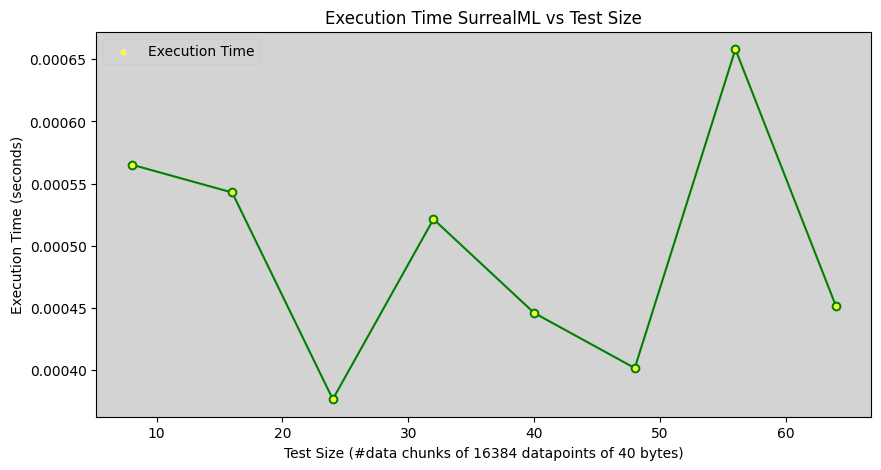

In [35]:
plt.rcParams["axes.facecolor"] = "#D3D3D3"
os.makedirs("./plots", exist_ok=True)

test_sizes = list(surreal_times.keys())
execution_times = list(surreal_times.values())

plt.figure(figsize=(10, 5))

plt.plot(test_sizes, execution_times, marker="o", color="green")
sns.scatterplot(
    x=test_sizes,
    y=execution_times,
    s=14,
    color="yellow",
    label="Execution Time",
    zorder=2,
)

plt.xlabel(f"Test Size (#data chunks of {chunk_size} datapoints of 40 bytes)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time SurrealML vs Test Size")
plt.legend()
plot_path = os.path.join(os.getcwd(), "plots", "execution_time_vs_test_size.png")
plt.savefig(plot_path)
plt.show()

In [36]:
@chronometer
def evaluate_pytorch(test_size, connect):
    inputs = connect.query(
        f"SELECT VALUE input FROM inputs LIMIT {test_size}"
    ).to_dict()["result"]

    with torch.no_grad():
        a = model.forward(torch.tensor(inputs))
        print(a, inputs)

In [37]:
pytorch_times = {}
try:
    with surreal.connect() as connect:
        for increment in range(number_steps):
            test_size = (increment + 1) * test_step

            elapsed_time = evaluate_pytorch(test_size, connect)
            print(
                f"For {test_size} collections of 10 by {chunk_size} datapoints, it took {elapsed_time} seconds"
            )
            pytorch_times[test_size] = elapsed_time
except Exception as e:
    print(e)

mat1 and mat2 shapes cannot be multiplied (1x0 and 10x5)


/tmp/ipykernel_55847/860893476.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


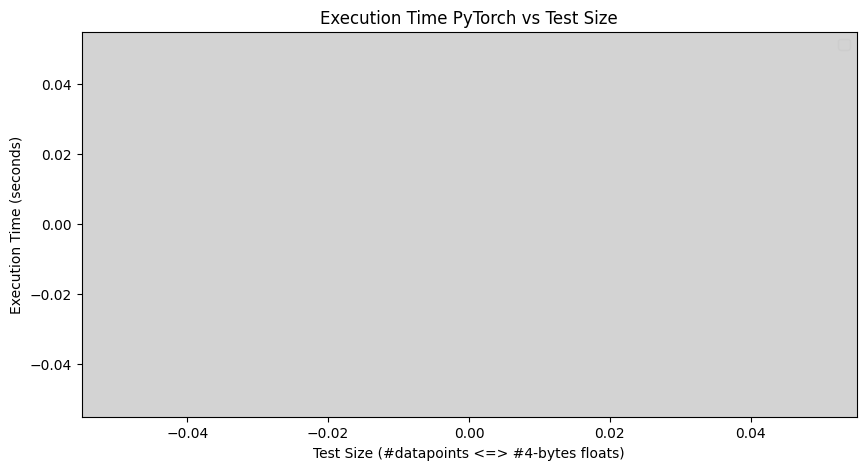

In [38]:
test_sizes = list(pytorch_times.keys())
execution_times = list(pytorch_times.values())

plt.figure(figsize=(10, 5))

plt.plot(test_sizes, execution_times, marker="o", color="orange")
sns.scatterplot(
    x=test_sizes,
    y=execution_times,
    s=14,
    color="black",
    label="Execution Time",
    zorder=2,
)

plt.xlabel("Test Size (#datapoints <=> #4-bytes floats)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time PyTorch vs Test Size")
plt.legend()
plot_path = os.path.join(os.getcwd(), "plots", "execution_time_vs_test_size.png")
plt.savefig(plot_path)
plt.show()

In [39]:
@chronometer
def evaluate_pytorch_without_surreal_query(inputs):
    with torch.no_grad():
        _ = model.forward(torch.tensor(inputs))

In [40]:
pytorch_without_surreal_times = {}
try:
    with surreal.connect() as connect:
        for increment in range(number_steps):
            test_size = (increment + 1) * test_step

            inputs = connect.query(
                f"SELECT VALUE input FROM inputs LIMIT {test_size}"
            ).to_dict()["result"]

            elapsed_time = evaluate_pytorch_without_surreal_query(inputs)
            print(
                f"For {test_size} collections of 10 by {chunk_size} datapoints, it took {elapsed_time} seconds"
            )
            pytorch_without_surreal_times[test_size] = elapsed_time
except Exception as e:
    print(e)

mat1 and mat2 shapes cannot be multiplied (1x0 and 10x5)


/tmp/ipykernel_55847/202465316.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


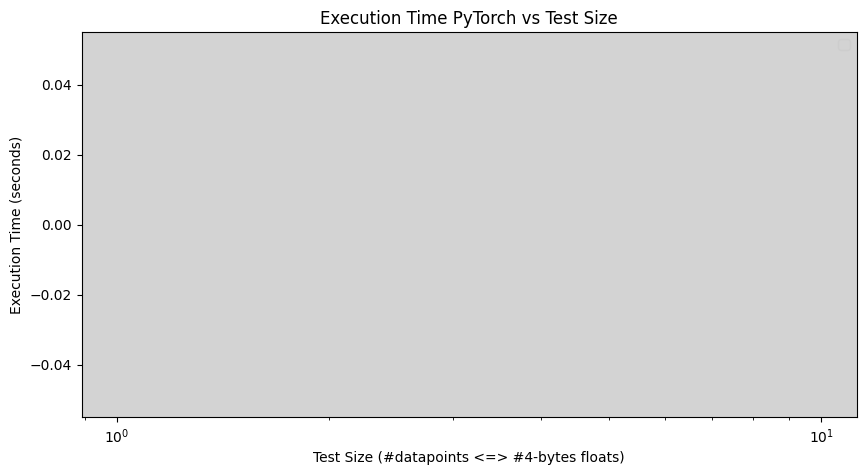

In [41]:
test_sizes = list(pytorch_without_surreal_times.keys())
execution_times = list(pytorch_without_surreal_times.values())

plt.figure(figsize=(10, 5))

plt.plot(test_sizes, execution_times, marker="o", color="orange")
sns.scatterplot(
    x=test_sizes,
    y=execution_times,
    s=14,
    color="black",
    label="Execution Time",
    zorder=2,
)

plt.xlabel("Test Size (#datapoints <=> #4-bytes floats)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time PyTorch vs Test Size")
plt.xscale("log")
# plt.yscale('log')
plt.legend()
plot_path = os.path.join(os.getcwd(), "plots", "execution_time_vs_test_size.png")
plt.savefig(plot_path)
plt.show()

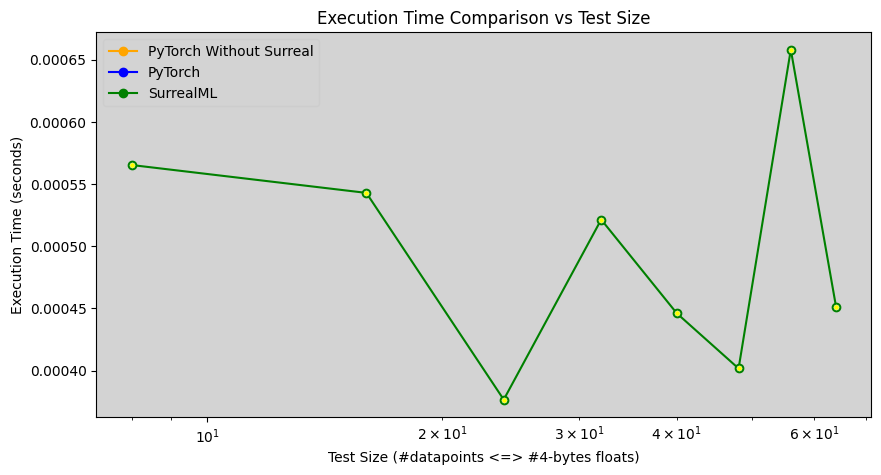

In [42]:
plt.rcParams["axes.facecolor"] = "#D3D3D3"
os.makedirs("./plots", exist_ok=True)

test_sizes_1 = list(pytorch_without_surreal_times.keys())
execution_times_1 = list(pytorch_without_surreal_times.values())
test_sizes_2 = list(pytorch_times.keys())
execution_times_2 = list(pytorch_times.values())
test_sizes_3 = list(surreal_times.keys())
execution_times_3 = list(surreal_times.values())

plt.figure(figsize=(10, 5))

plt.plot(
    test_sizes_1,
    execution_times_1,
    marker="o",
    color="orange",
    label="PyTorch Without Surreal",
)
sns.scatterplot(
    x=test_sizes_1,
    y=execution_times_1,
    s=14,
    color="black",
    zorder=2,
)

plt.plot(test_sizes_2, execution_times_2, marker="o", color="blue", label="PyTorch")
sns.scatterplot(
    x=test_sizes_2,
    y=execution_times_2,
    s=14,
    color="red",
    zorder=2,
)

plt.plot(test_sizes_3, execution_times_3, marker="o", color="green", label="SurrealML")
sns.scatterplot(
    x=test_sizes_3,
    y=execution_times_3,
    s=14,
    color="yellow",
    zorder=2,
)

plt.xlabel("Test Size (#datapoints <=> #4-bytes floats)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison vs Test Size")
plt.xscale("log")
plt.legend()

plot_path = os.path.join(os.getcwd(), "plots", "execution_time_vs_test_size.png")
plt.savefig(plot_path)
plt.show()